# Evaluating a parsimonious neural network (PNN) model - non linear potential #

<i>Saaketh Desai</i>, and <i>Alejandro Strachan</i>, School of Materials Engineering, Purdue University <br>

This notebook evaluates a parsimonious neural network generated by the optimization algorithm in the [previous notebook](discover_pnn.ipynb). The outline of this notebook is:

1. Express network weights as interpretable equations
2. Read training and testing data
3. Create model and set weights to values obtained from optimization
4. Evaluate model metrics on datasets and the objective function as per the genetic algorithm
5. Visually inspect trajectories generated by the PNN
6. Evaluate energy conservation and time reversibility

In [3]:
import tensorflow as tf
import keras
from keras import backend as K
from keras import initializers
from keras.layers import Dense, Input, Activation
from keras.models import Sequential, Model, load_model
from keras.layers.merge import add, concatenate

from sklearn.model_selection import train_test_split

import numpy as np
import sys
import os
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca

We again define globally relevant parameters and units

In [4]:
#x = pm; t = fs => v = pm/fs; a = pm/fs^2
natoms = 2
mass = 26.982
timestep = 1.0
constant = 9.648532952214415e-1

## Step 1: Express network weights as equations##
We find that the best performing networks discovered by the genetic algorithm all have linear activations, implying that we can easily write the outputs of network in terms of the inputs and weights, using the network architecture. We can also go one step ahead and write this relationship in terms of the position Verlet algorithm. Doing this requires expressing the input-output mapping in terms of familiar quantities such as timestep and mass. The following three cells do just that.

We first write down weight values for PNN model in a list

In [5]:
weight_values = [1., 0.5, 0., 0.5, 1., 0., 0., 0.8888887, 2., 0.2227591, 
                 2., 0.03705336, 1., 0.5, 0., -1.9999998, 0.5, 0., 1., 0.5]

In [6]:
c1 = weight_values[6]*weight_values[0] + weight_values[7]*weight_values[2]
c2 = weight_values[6]*weight_values[1] + weight_values[7]*weight_values[3]
c3 = weight_values[8]*weight_values[0] + weight_values[9]*weight_values[2]
c4 = weight_values[8]*weight_values[1] + weight_values[9]*weight_values[3]

d1 = weight_values[10]*c1 + weight_values[12]*c3
d2 = weight_values[10]*c2 + weight_values[12]*c4
d3 = weight_values[13]*c1 + weight_values[15]*c3
d4 = weight_values[13]*c2 + weight_values[15]*c4

fi_x = weight_values[4]*weight_values[0] + weight_values[5]*weight_values[2]
fi_v = weight_values[4]*weight_values[1] + weight_values[5]*weight_values[3]

x_coeff_x = weight_values[16]*d1 + weight_values[17]*d3
x_coeff_v = weight_values[16]*d2 + weight_values[17]*d4
x_coeff_f = weight_values[16]*weight_values[11] + weight_values[17]*weight_values[14]

v_coeff_x = weight_values[18]*d1 + weight_values[19]*d3
v_coeff_v = weight_values[18]*d2 + weight_values[19]*d4
v_coeff_f = weight_values[18]*weight_values[11] + weight_values[19]*weight_values[14]

We express the position and velocity at $t + \Delta t$ as a linear function of three variables: the position at time $t$, the velocity at time $t$ and the force. Thus, for the position at $t + \Delta t$, we have three coefficients which should be 1, $\Delta t$ and $\frac{{\Delta t}^2}{m}$. We find our coefficients to be approximately the same.

The velocity at $t+\Delta t$ should have coefficients of 0, 1 and $\frac{\Delta t}{m}$ for the three terms. Again, we find our PNN model to discover the coefficients almost exactly.

Lastly, we evaluate the coefficients of the terms that are inputs to the force block of the PNN. In the position Verlet algorithm, these coefficients should be 1 and $\frac{\Delta t}{2}$, which is what we find for the PNN model.

In [7]:
print (x_coeff_x, x_coeff_v, x_coeff_f)
print (v_coeff_x, v_coeff_v, v_coeff_f)
print (fi_x, fi_v)

print (x_coeff_x, x_coeff_v/timestep, x_coeff_f*2*mass/timestep**2)
print (v_coeff_x, v_coeff_v, v_coeff_f*mass/timestep)
print (fi_x, fi_v*2/timestep)

1.0 1.000134125 0.01852668
1.9999999989472883e-07 0.9999998986379548 0.03705336
1.0 0.5
1.0 1.000134125 0.99977375952
1.9999999989472883e-07 0.9999998986379548 0.99977375952
1.0 1.0


In our case, the final discovered PNN model can be written as:
<br> $ x(t+\Delta t) = x(t) + 1.0001 v(t)\Delta t + 0.9993  \frac{1}{2} f(x(t) + v(t)\frac{\Delta t}{2})\frac{{\Delta t}^2}{m} $ </br>
<br> $ v(t+\Delta t) = v(t) + 0.9992 f(x(t) + v(t)\frac{\Delta t}{2}) \frac{\Delta t}{m} $ </br>

## Step 2: Read datasets
Just as in the training notebook, we define the paths to the LAMMPS dump files containing the training and testing data. We then read it in using the helper function below, following which re-create the training and testing sets using the `train_test split()` method from scikit-learn, just as in training

In [8]:
def read_files(documents):
    input_storage = []; output_storage = []

    for file in documents:
        with open(file) as f:
            data = f.readlines()

        n=9+natoms
        data = data[n-2::n]
        data = [x.strip().split() for x in data] # First atom    
        data = np.array([[float(item) for item in sublist] for sublist in data]) #Turn strings into floats

        x = data[:,1].reshape(len(data),1)*100 
        vx = data[:,4].reshape(len(data),1)/10
        fx = (data[:,7]).reshape(len(data),1)

        data_xv = np.concatenate((x,vx,fx), axis=1)

        input_storage.append(data_xv[:-10:10,:])
        output_storage.append(data_xv[10::10,:])


    total_length_list = [len(i) for i in input_storage]
    total_length = sum(total_length_list)

    inputs = np.zeros((total_length, 3))
    outputs = np.zeros((total_length, 3))
    start = 0; end = 0
    for i in range(len(documents)):
        end += len(input_storage[i]) 
        inputs[start:end, :] = input_storage[i]
        outputs[start:end, :] = output_storage[i]
        start = end

    print("Inputs", inputs.shape)
    print("Outputs", outputs.shape)
    
    return inputs,outputs

In [9]:
documents = ["../data/Al_3K_small.dump", 
             "../data/Al_273K_small.dump", 
             "../data/Al_530K_small.dump", 
             "../data/Al_703K_small.dump"]

inputs, outputs = read_files(documents)
documents = ["../data/Al_300K_small.dump"]
test_inputs, test_outputs = read_files(documents)

train_inputs, val_inputs, train_outputs, val_outputs = train_test_split(inputs[:,0:2], outputs[:,0:2], 
                                                                        test_size=0.2, random_state=0)

Inputs (40000, 3)
Outputs (40000, 3)
Inputs (10000, 3)
Outputs (10000, 3)


## Step 3: Create model and set weights to values obtained from optimization

We are now ready to setup the neural network with parameters obtained from the optimization. We will first define variables relevant to setting up the model, following which we read in the parameters for the pre-trained force model, keeping those weights fixed

In [12]:
act_dict = {0: 'linear', 1: 'relu', 2: 'tanh', 3: 'linear'}
np.random.seed(123456)
weight_dict = {0: 0, 1: 0.5, 2: 1, 3: 2, 4: timestep/2, 5: timestep, 6: 2*timestep, 7: np.random.uniform(-1,1,1)[0]}
nact_terms = 6
nweight_terms = 20

In [14]:
model = tf.keras.models.load_model('../data/force_model_small.h5')
w1 = model.layers[1].get_weights()
w2 = model.layers[2].get_weights()
w3 = model.layers[3].get_weights()

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Colocations handled automatically by placer.


The next few functions help re-create the trained PNN model. In the <i> create_model() </i> function, we set the weights of the appropriate layers in the network to be the weights obtained after the optimization in the [previous notebook](discover_pnn.ipynb).

In [15]:
def create_node(input1, input2, name, trainable1, trainable2, act):
    base = name
    n1 = base + "1"
    n2 = base + "2"
    an1 = Dense(1, activation = 'linear', use_bias = False, name=n1, trainable=trainable1) (input1)
    an2 = Dense(1, activation = 'linear', use_bias = False, name=n2, trainable=trainable2) (input2)
    an = add([an1, an2])
    an = Activation(act) (an)
    return an

In [16]:
def create_model(x):
    initializer = keras.initializers.glorot_normal(seed=123456)
    bias_initial = keras.initializers.Zeros()
   
    trainable_list = []
    for i in range(nweight_terms):
        if (x[i+nact_terms] == 7):
            trainable_list.append(True)
        else:
            trainable_list.append(False)

    input_position = Input(shape=(1,))
    input_velocity = Input(shape=(1,))
    
    #a1
    a1 = create_node(input_position, input_velocity, "a1", trainable_list[0], trainable_list[1], act_dict[x[0]])
    #a2
    a2 = create_node(input_position, input_velocity, "a2", trainable_list[2], trainable_list[3], act_dict[x[1]])
    #a3
    a3 = create_node(a1, a2, "a3", trainable_list[4], trainable_list[5], act_dict[x[2]])
    #a4
    a4 = create_node(a1, a2, "a4", trainable_list[6], trainable_list[7], act_dict[x[3]])
    #force_input
    force_input = create_node(a1, a2, "fi", trainable_list[8], trainable_list[9], 'linear')
    
    #force at time t+delta_t/2 from halfstep position
    force1 = Dense(10, activation='tanh', use_bias = True, name='force_middle_layer', trainable=False)(force_input)
    force2 = Dense(10, activation='tanh', use_bias = True, name='force_middle_layer_2', trainable=False) (force1)
    force_output = Dense(1, activation='linear', use_bias = True, name='force_output_layer', trainable=False)(force2)

    #a5
    a51 = Dense(1, activation = 'linear', use_bias = False, name="a51", trainable=trainable_list[10]) (a3)
    a52 = Dense(1, activation = 'linear', use_bias = False, name="a52", trainable=trainable_list[11]) (force_output)
    a53 = Dense(1, activation = 'linear', use_bias = False, name="a53", trainable=trainable_list[12]) (a4)
    a5 = add([a51, a52, a53])
    a5 = Activation(act_dict[x[4]]) (a5)
    
    #a6
    a61 = Dense(1, activation = 'linear', use_bias = False, name="a61", trainable=trainable_list[13]) (a3)
    a62 = Dense(1, activation = 'linear', use_bias = False, name="a62", trainable=trainable_list[14]) (force_output)
    a63 = Dense(1, activation = 'linear', use_bias = False, name="a63", trainable=trainable_list[15]) (a4)
    a6 = add([a61, a62, a63])
    a6 = Activation(act_dict[x[5]]) (a6)
    
    #output_position
    output_position = create_node(a5, a6, "op", trainable_list[16], trainable_list[17], "linear")
    
    #output_velocity
    output_velocity = create_node(a5, a6, "ov", trainable_list[18], trainable_list[19], "linear")
     
    model = Model(inputs=[input_position, input_velocity], outputs=[output_position, output_velocity])
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)

    # FREEZING WEIGHTS
    model.layers[16].set_weights(w1)
    model.layers[20].set_weights(w2)
    model.layers[23].set_weights(w3)

    # SETTING OTHER WEIGHTS
    
    layer_list = []
    for i in range(2, 6):
        layer_list.append(i)
    for i in [10, 11, 14, 15, 17, 18]:
        layer_list.append(i)
    for i in range(25, 31):
        layer_list.append(i)
    for i in range(35, 39):
        layer_list.append(i)
    
    for i in range(len(layer_list)):
        model.layers[layer_list[i]].set_weights( [ np.array( [[ weight_values[i] ]] ) ] )
    
    return model, trainable_list, layer_list

We now define the individual found to be the best according to the genetic algorithm, using the individual's attributes to create the model. This affects the evaluation of the genetic algorithm objective function, as the penalties for non-linear activations and trainable weights are decided by the individual

In [18]:
correct_individual = [0, 0, 0, 0, 0, 0, 5, 1, 0, 1, 2, 0, 0, 7, 6, 7, 6, 7, 5, 1, 0, 7, 4, 0, 5, 4]

new_model, trainable, layers = create_model(correct_individual)
print("Model weights")
for i in layers:
    print (new_model.layers[i].get_weights()[0])

Model weights
[[1.]]
[[0.5]]
[[0.]]
[[0.5]]
[[1.]]
[[0.]]
[[0.]]
[[0.8888887]]
[[2.]]
[[0.2227591]]
[[2.]]
[[0.03705336]]
[[1.]]
[[0.5]]
[[0.]]
[[-1.9999998]]
[[0.5]]
[[0.]]
[[1.]]
[[0.5]]


## Step 4: Evaluate model metrics on datasets and the objective function as per the genetic algorithm

We begin by evaluating the mean squared error (the metric used for training) for the training, validation and testing sets

In [20]:
mse_train = new_model.evaluate([train_inputs[:,0], train_inputs[:,1]], [train_outputs[:,0], train_outputs[:,1]])
mse_val = new_model.evaluate([val_inputs[:,0], val_inputs[:,1]], [val_outputs[:,0], val_outputs[:,1]])
mse_test = new_model.evaluate([test_inputs[:,0], test_inputs[:,1]], [test_outputs[:,0], test_outputs[:,1]])

print ("MSE on training set: ", mse_train)
print ("MSE on validation set: ", mse_val)
print ("MSE on test set: ", mse_test)

10000/10000 [==============================] - 0s 20us/step
MSE on training set:  [2.6451779863156942e-09, 2.201088025233222e-09, 4.440899565097411e-10]
MSE on validation set:  [2.6760927445135253e-09, 2.2221298394686785e-09, 4.539629107624954e-10]
MSE on test set:  [1.6081453479976915e-09, 1.4077551650615306e-09, 2.0039018202577808e-10]


We will now re-create the objective function of the genetic algorithm, evaluating it for the individual

In [21]:
def objective_function(new_model, individual):

    loss, mse_test_x, mse_test_v = new_model.evaluate([test_inputs[:,0:1], test_inputs[:,1:2]], 
                                                      [test_outputs[:,0:1], test_outputs[:,1:2]], verbose=0)
    actfunc_term = [i**2 for i in individual[:nact_terms]]
    weights = individual[nact_terms:]
    weight_term = 0
    for j in range(nweight_terms):
        weight_term += f3(weights[j])
        
    mse_test_term_x = 10*np.log10(mse_test_x)
    mse_test_term_v = 10*np.log10(mse_test_v)
    
    obj = mse_test_term_x + mse_test_term_v + np.sum(actfunc_term) + weight_term
    print ("Individual: ", individual, flush=True)
    print ("Objective function: ", mse_test_x, mse_test_v, np.sum(actfunc_term), weight_term, obj, flush=True)
    return new_model

In [22]:
def f3(w):
    if (w == 0):
        return 0
    elif (w >= 1 and w <= 6):
        return 1
    elif (w == 7):
        return 2

Evaluating the objective function for this case gives a value of -166.5, which is close to the objective function value for the position Verlet algorithm, -169

In [24]:
objective_function(new_model, correct_individual)

Individual:  [0, 0, 0, 0, 0, 0, 5, 1, 0, 1, 2, 0, 0, 7, 6, 7, 6, 7, 5, 1, 0, 7, 4, 0, 5, 4]
Objective function:  1.4077551650615306e-09 2.0039018202577808e-10 0 19 -166.49596430787494


## Step 5: Visually inspect trajectories generated by the PNN

The next two functions use the PNN model to generate a trajectory, and plot the data alongside the training/testing data for a quick visual comparison of the trajectories generated

In [25]:
def run_NN(init_pos, init_vel, timestep, total_time, model):
    
    time_array = np.arange(0, total_time, timestep)
    pos = np.zeros(len(time_array))
    vel = np.zeros(len(time_array))
    pos[0] = init_pos
    vel[0] = init_vel
    
    eval_inputs = [np.array([init_pos]), np.array([init_vel])]
    
    for frame in range(len((time_array))-1):
        p = model.predict(eval_inputs)
        pos[frame+1] = p[0][0][0]
        vel[frame+1] = p[1][0][0]
        eval_inputs = [ np.array( [ p[0][0][0] ] ), np.array( [ p[1][0][0] ] ) ]
        
    return pos, vel, time_array

In [26]:
def plot_trajectory(step, time, data_slice, y1, y2):
    
    x_axis = np.arange(0, time, step)[:data_slice]
    fig, axes = plt.subplots(figsize=(24,12))
    plt.plot(x_axis, y1[:data_slice], 'r-', label='Training Data')
    plt.plot(x_axis, y2[:data_slice], 'b-', label='NN')
    plt.xlabel("Time (ps)", fontsize=20)
    plt.ylabel("Position (Å)", fontsize=20)
    axes.set_xticklabels([round(x,3) for x in axes.get_xticks()], fontsize=20)
    axes.set_yticklabels([round(y,3) for y in axes.get_yticks()], fontsize=20)
    plt.legend(bbox_to_anchor=(1.05, 0.5), fontsize =20)
    plt.grid()
    plt.show()
    
    return

Inputs (10000, 3)
Outputs (10000, 3)


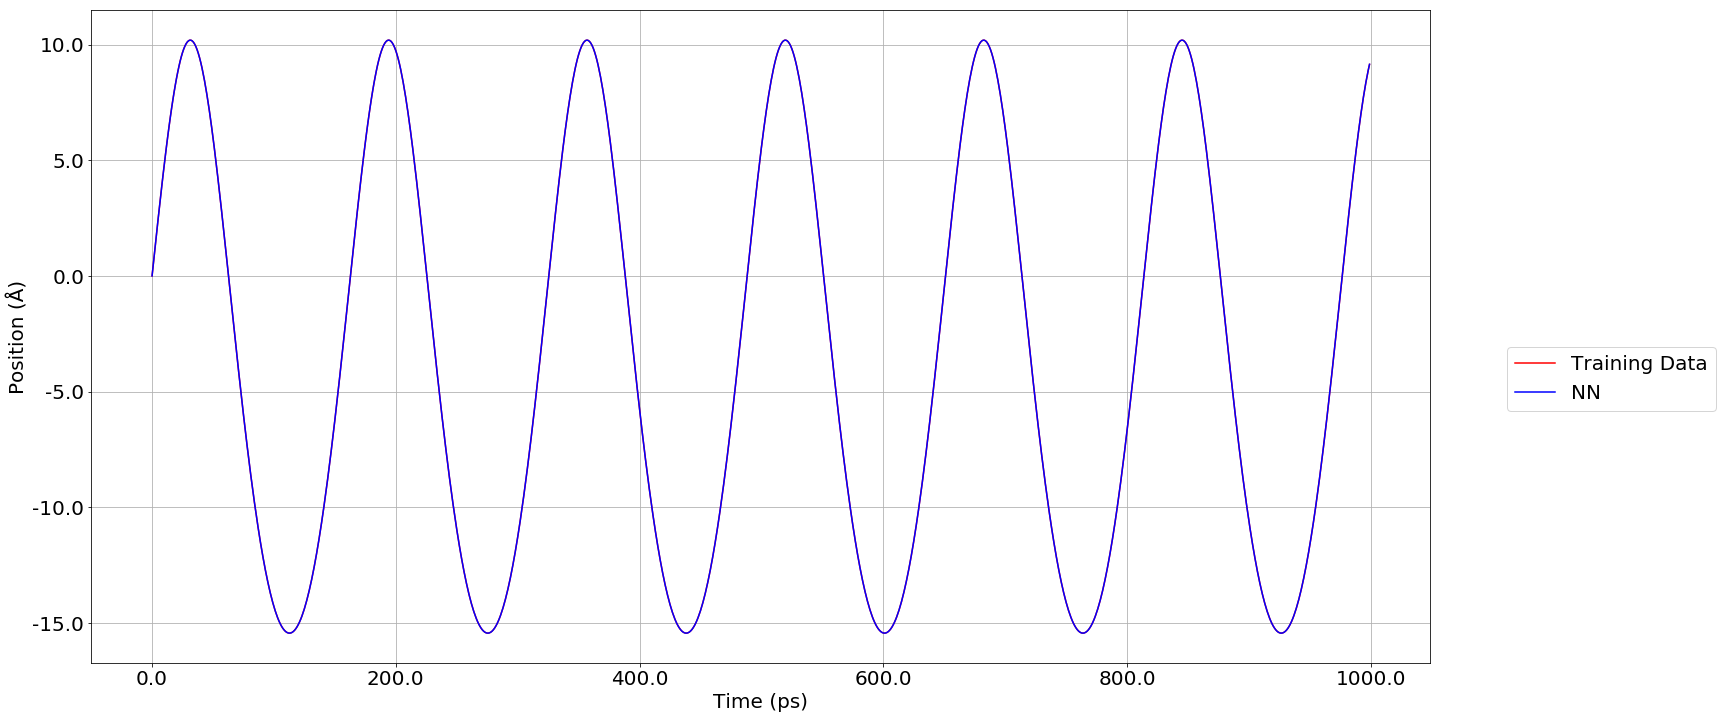

In [27]:
documents = ["../data/Al_273K_small.dump"]
train_viz_inputs, train_viz_outputs = read_files(documents)
pos, vel, time_array = run_NN(train_viz_inputs[0][0], train_viz_inputs[0][1], 1, 1000, new_model)
plot_trajectory(1, 1000, 1000, train_viz_inputs[:,0], pos)

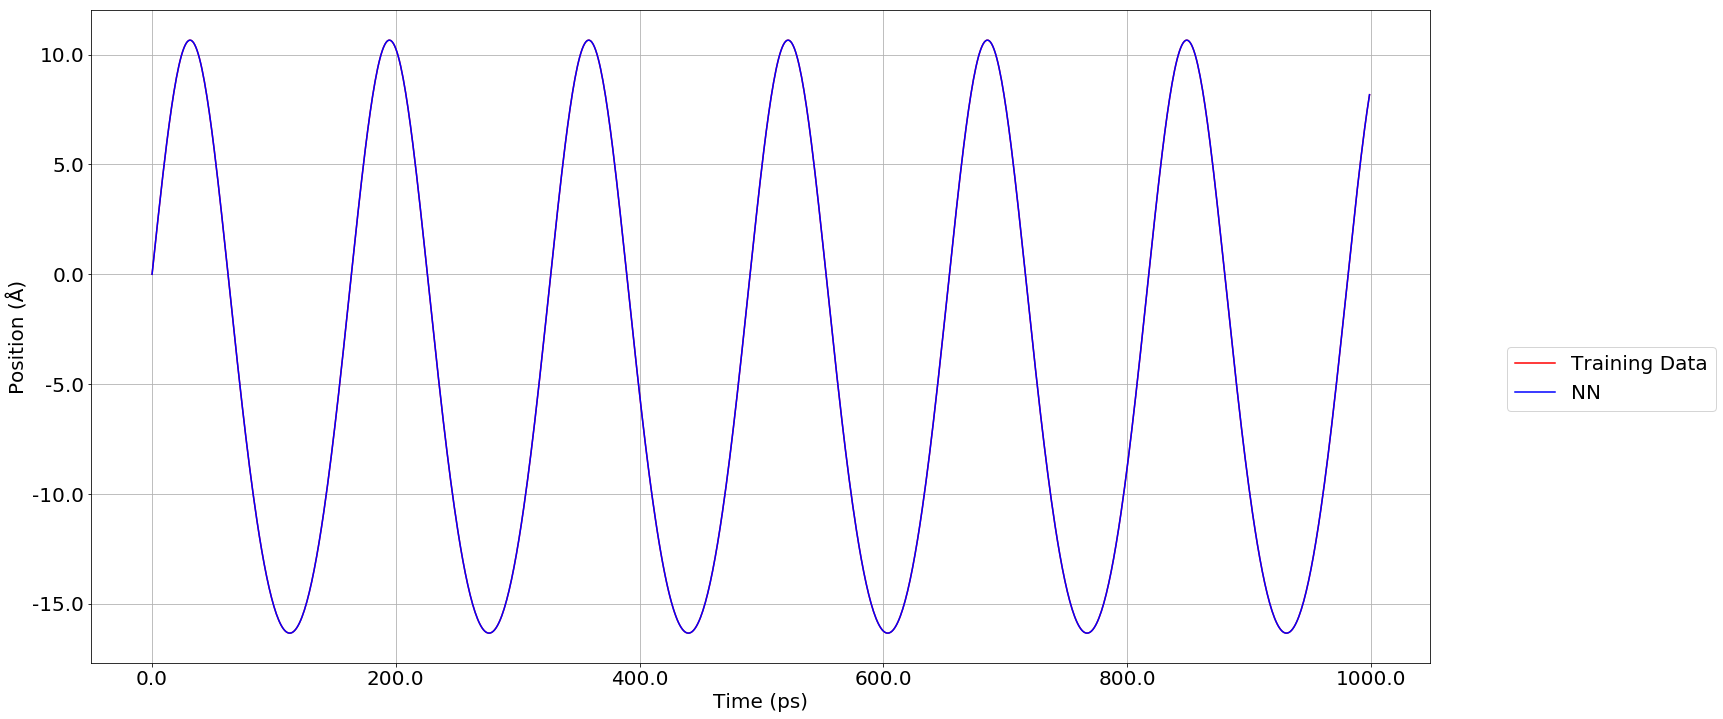

In [28]:
pos, vel, time_array = run_NN(test_inputs[0][0], test_inputs[0][1], 1, 1000, new_model)
plot_trajectory(1, 1000, 1000, test_inputs[:,0], pos)

## Step 6: Evaluate energy conservation and time reversibility

Knowing that the particles interact with the Lennard Jones potential, we can compute  the potential and kinetic energy and evaluate the extent to which total energy is conserved

In [29]:
def compute_pe(x):
    
    sigma = 2.5
    epsilon = 0.5
    
    r = np.abs(x - 280)
    sigma_over_r = sigma*100/r #100 is converting sigma to pm
    pe = 4*epsilon*(sigma_over_r**12 - sigma_over_r**6)
    
    return pe

def compute_ke(v):
    
    ke = 0.5*mass*v*v*1e-2/constant
    
    return ke

In [31]:
#run forward (starting from arbitrary position and velocity within training set) for 10000 steps
pos_f, vel_f, time_array_f = run_NN(test_inputs[0][0], test_inputs[0][1], 1, 1000, new_model)

In [32]:
pred_pe = compute_pe(pos_f)
pred_ke = compute_ke(vel_f)
pred_te = pred_pe + pred_ke

In [33]:
true_pe = compute_pe(test_inputs[:,0])
true_ke = compute_ke(test_inputs[:,1])
true_te = true_pe + true_ke

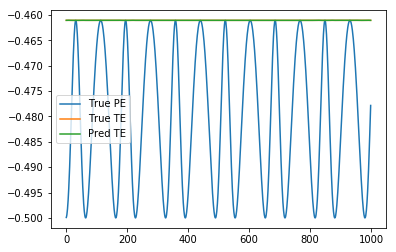

In [34]:
plt.plot(true_pe[:1000], label='True PE')
#plt.plot(true_ke[:1000], label='True KE')
plt.plot(true_te[:1000], label='True TE')
plt.plot(pred_te[:1000], label='Pred TE')
plt.legend()

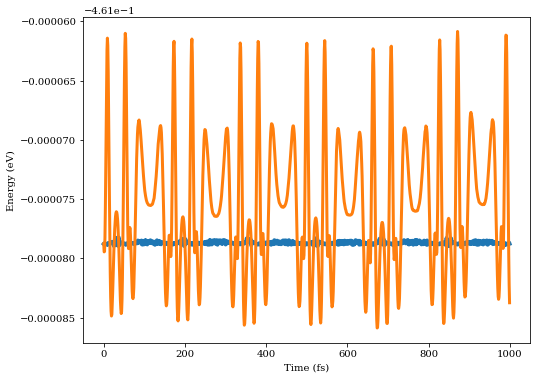

In [35]:
plt.rc('font', family='serif')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Time (fs)')
ax.set_ylabel('Energy (eV)')
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=25)

#ax.set_ylim((-0.505, -0.43))

#plt.plot(true_pe[:1000], linewidth=3, label='True PE')
#plt.plot(true_ke[:1000], label='True KE')
plt.plot(true_te[:1000], linewidth=4, label='True TE')
plt.plot(pred_te[:1000], linewidth=3, label='Pred TE')
#plt.legend()

Finally we can evaluate the time reversibility: we do this by running the trajectory forward for 1000 steps, reversing the velocity and running a 1000 step integration. In an ideal case, the position at the end of the run should be identical to the initial position and velocity should be identical in magnitude and of the opposite sign. We visually inspect this with a plot, also computing the error in position and velocity

Mean error in pos:  5.930842459201813e-05
Std error in pos:  0.0003311181273751006
Mean error in vel:  -3.719429969788468e-07
Std error in vel:  1.3006849852311304e-05


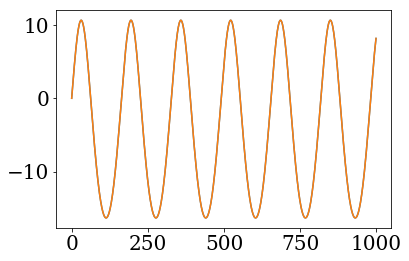

In [36]:
#run forward (starting from arbitrary position and velocity within training set) for 10000 steps
pos_f, vel_f, time_array_f = run_NN(test_inputs[0][0], test_inputs[0][1], 1, 1000, new_model)
#run backward for 10000 steps
pos_b, vel_b, time_array_b = run_NN(pos_f[-1], -vel_f[-1], 1, 1000, new_model)

error_x = pos_f - pos_b[::-1]
print ("Mean error in pos: ", np.mean(error_x))
print ("Std error in pos: ", np.std(error_x))

error_v = vel_f - -vel_b[::-1]
print ("Mean error in vel: ", np.mean(error_v))
print ("Std error in vel: ", np.std(error_v))

plt.plot(pos_f)
plt.plot(pos_b[::-1])

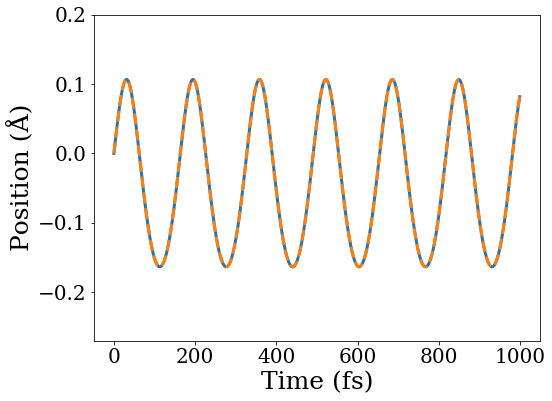

In [37]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
ax.set_xlabel('Time (fs)')
ax.set_ylabel('Position (Å)')

ax.set_ylim((-0.27, 0.20))

plt.plot(pos_f/100, linewidth=3, label='Forward')
plt.plot(pos_b[::-1]/100, linewidth=3, label='Reverse', linestyle='--')

We now manually evaluate the mean squared error and report it in LJ units

In [38]:
preds_train = new_model.predict([train_inputs[:, 0], train_inputs[:, 1]])
preds_val = new_model.predict([val_inputs[:, 0], val_inputs[:, 1]])
preds_test = new_model.predict([test_inputs[:, 0], test_inputs[:, 1]])

error_train_x = preds_train[0] - train_outputs[:, 0:1]
error_train_v = preds_train[1] - train_outputs[:, 1:2]

error_val_x = preds_val[0] - val_outputs[:, 0:1]
error_val_v = preds_val[1] - val_outputs[:, 1:2]

error_test_x = preds_test[0] - test_outputs[:, 0:1]
error_test_v = preds_test[1] - test_outputs[:, 1:2]

In [39]:
mse_train_x = np.sqrt(np.mean(error_train_x**2))
mse_train_v = np.sqrt(np.mean(error_train_v**2))

mse_val_x = np.sqrt(np.mean(error_val_x**2))
mse_val_v = np.sqrt(np.mean(error_val_v**2))

mse_test_x = np.sqrt(np.mean(error_test_x**2))
mse_test_v = np.sqrt(np.mean(error_test_v**2))

print (mse_train_x, mse_train_v, mse_val_x, mse_val_v, mse_test_x, mse_test_v)

4.6915940917151634e-05 2.1073443218261242e-05 4.713560146282443e-05 2.1306550754667027e-05 3.752114747231765e-05 1.4155880295099208e-05


In [40]:
print (np.around(mse_train_x*0.004, decimals=9))
print (np.around(mse_train_v*0.03344, decimals=9))

print (np.around(mse_val_x*0.004, decimals=9))
print (np.around(mse_val_v*0.03344, decimals=9))

print (np.around(mse_test_x*0.004, decimals=9))
print (np.around(mse_test_v*0.03344, decimals=9))

1.88e-07
7.05e-07
1.89e-07
7.12e-07
1.5e-07
4.73e-07
